In [1]:
from mps_class_v9 import MPS
import numpy as np
from utils import tensor_shapes, H_ising_gen, mpo_to_matrix, mps_to_vector, truncation
from ncon import ncon
import scipy
from scipy.linalg import expm
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

In [2]:
def update_state_var(classe, sweep, site):
    if sweep == "right":
        # we want to write M (left,d,right) in LFC -> (left*d,right)
        m = classe.sites[site - 1].reshape(
            classe.env_left[-1].shape[0] * classe.d, classe.env_right[-1].shape[0]
        )
        u, s, v = np.linalg.svd(m, full_matrices=False)
        u = u.reshape(
            classe.env_left[-1].shape[0], classe.d, classe.env_right[-1].shape[0]
        )
        classe.sites[site - 1] = u
    elif sweep == "left":
        # we want to write M (left,d,right) in RFC -> (left,d*right)
        m = classe.sites[site - 1].reshape(
            classe.env_left[-1].shape[0], classe.d * classe.env_right[-1].shape[0]
        )
        u, s, v = np.linalg.svd(m, full_matrices=False)
        v = v.reshape(
            classe.env_left[-1].shape[0], classe.d, classe.env_right[-1].shape[0]
        )
        classe.sites[site - 1] = v

In [30]:
def lin_sys(classe, M, N_eff, site):
    M_new = M.flatten()
    new_site = scipy.linalg.solve(N_eff, M_new)
    new_site = new_site.reshape((classe.env_left[-1].shape[2], classe.d, classe.env_right[-1].shape[2]))
    classe.sites[site - 1] = new_site
    return classe

In [31]:
def time_ev_sweeping(classe, trunc, delta, h_ev, J_ev, e_tol=10 ** (-15), n_sweeps=2, precision=2):
    sweeps = ["right", "left"]
    sites = np.arange(1, classe.L + 1).tolist()
    errors = []

    # computation of mixed environments
    classe.mpo_Ising_time_ev(delta=delta, h_ev=h_ev, J_ev=J_ev)
    classe.envs(site=1, mixed=True)
    iter = 1
    for n in range(n_sweeps):
        print(f"Sweep n: {n}\n")
        for i in range(classe.L - 1):
            N_eff = classe.N_eff(site=sites[i])
            classe, M = classe.contraction_with_ancilla(sites[i])
            lin_sys(classe, M, N_eff, sites[i])
            err = classe.error(site=sites[i], N_eff=N_eff, M=M)
            print(f"error per site {sites[i]}: {err:.5f}")
            errors.append(err)
            classe.update_state(sweeps[0], sites[i], trunc, e_tol, precision)
            classe.update_envs(sweeps[0], sites[i], mixed=True)
            iter += 1

        sweeps.reverse()
        sites.reverse()

    return classe, errors[-1]

In [32]:
def TEBD_ising(classe, trunc, trotter_steps, delta, h_ev, J_ev, e_tol=10 ** (-15), n_sweeps=4, precision=2):
    errors = []
    classe.clear_envs()
    for i in range(trotter_steps):
        print("\n======================")
        print(f"Trotter step: {i}")
        print("======================\n")
        classe, err = time_ev_sweeping(classe, trunc, delta, h_ev, J_ev, e_tol=10 ** (-15), n_sweeps=2, precision=2)
        errors.append(err)
        print(f"Error at trotter step {i}: {err:.5f}")
    return classe, errors

In [33]:
trotter_steps = [1]
energies = []
# phi compressed and variational
chain = MPS(L=20, d=2, model="Ising", chi=16, h=0.1, J=1, eps=0)
chain._random_state(seed=7, chi=16)
chain.canonical_form()
chain.sweeping(trunc=False, n_sweeps=2)
chain._compute_norm(site=1)

# psi uncompressed and fixed
guess = MPS(L=20, d=2, model="Ising", chi=64, h=0.1, J=1, eps=0)
guess._random_state(seed=7, chi=64)
guess.canonical_form()
guess.sweeping(trunc=False, n_sweeps=2)
guess._compute_norm(site=1)

chain.ancilla_sites = guess.sites
chain.canonical_form(ancilla=True)
# chain._random_state(seed=5, chi=chain.chi, ancilla=True)
# chain.canonical_form(ancilla=True)

Sweep n: 0


Optimal Schmidt values achieved, breaking the DMRG optimization algorithm

Sweep n: 1


Optimal Schmidt values achieved, breaking the DMRG optimization algorithm

The left overlap of the state:
[[[[1]]]]
The right overlap of the state:
[[[[ 1.00000000e+00]]

  [[-2.07604387e-16]]]


 [[[-2.07597611e-16]]

  [[ 1.00000000e+00]]]]
The tensor in the site 1:
[[[[ 9.99993746e-01 -8.13595422e-20]
   [-8.13595422e-20  6.25396008e-06]]]]
-=-=-= Norm: 1.0000000000000007

Sweep n: 0


Optimal Schmidt values achieved, breaking the DMRG optimization algorithm

Sweep n: 1


Optimal Schmidt values achieved, breaking the DMRG optimization algorithm

The left overlap of the state:
[[[[1]]]]
The right overlap of the state:
[[[[1.00000000e+00]]

  [[8.81591892e-18]]]


 [[[8.82269518e-18]]

  [[1.00000000e+00]]]]
The tensor in the site 1:
[[[[9.99993746e-01 3.43726814e-19]
   [3.43726814e-19 6.25396008e-06]]]]
-=-=-= Norm: 1.0000000000000033



In [15]:
trotter_steps = range(5)
for trott in trotter_steps:
    chain, errors = TEBD_ising(chain, trunc=False, trotter_steps=trott, delta=0.05, h_ev=0.2, J_ev=1)
    chain.clear_envs()
    chain.mpo_Ising()
    chain.envs()
    energies.append(chain.braket(site=1))


Trotter step: 0

Sweep n: 0

(1, 1)
(2, 2)
error A^dagger N_eff A: (0.9995573127228967-5.551115123125783e-17j)
error A^dagger M: (0.9995573127228967-5.551115123125783e-17j)
Total error: (-0.9995573127228967-5.551115123125783e-17j)
error per site 1: -0.99956-0.00000j
(2, 2)
(4, 4)
error A^dagger N_eff A: (0.9996064950002037+0j)
error A^dagger M: (0.9996064950002037+0j)
Total error: (-0.9996064950002037+0j)
error per site 2: -0.99961+0.00000j
(4, 4)
(8, 8)
error A^dagger N_eff A: (0.9996554511179169-1.3877787807814457e-17j)
error A^dagger M: (0.9996554511179169-1.3877787807814457e-17j)
Total error: (-0.9996554511179169-1.3877787807814457e-17j)
error per site 3: -0.99966-0.00000j
(8, 8)
(16, 16)
error A^dagger N_eff A: (0.9996798408769713+0j)
error A^dagger M: (0.9996798408769713+0j)
Total error: (-0.9996798408769713+0j)
error per site 4: -0.99968+0.00000j
(16, 16)
(16, 16)
error A^dagger N_eff A: (0.9996851679364255+2.7755575615628914e-17j)
error A^dagger M: (0.9996851679364255+2.775557

In [16]:
tensor_shapes(chain.sites)

(1, 2, 2)
(2, 2, 4)
(4, 2, 8)
(8, 2, 16)
(16, 2, 16)
(16, 2, 16)
(16, 2, 16)
(16, 2, 16)
(16, 2, 16)
(16, 2, 16)
(16, 2, 16)
(16, 2, 16)
(16, 2, 16)
(16, 2, 16)
(16, 2, 16)
(16, 2, 16)
(16, 2, 8)
(8, 2, 4)
(4, 2, 2)
(2, 2, 1)


[(1, 2, 2),
 (2, 2, 4),
 (4, 2, 8),
 (8, 2, 16),
 (16, 2, 16),
 (16, 2, 16),
 (16, 2, 16),
 (16, 2, 16),
 (16, 2, 16),
 (16, 2, 16),
 (16, 2, 16),
 (16, 2, 16),
 (16, 2, 16),
 (16, 2, 16),
 (16, 2, 16),
 (16, 2, 16),
 (16, 2, 8),
 (8, 2, 4),
 (4, 2, 2),
 (2, 2, 1)]

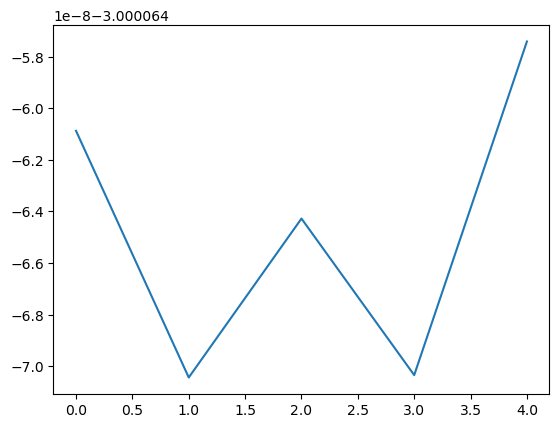

In [ ]:
plt.plot(errors)

3.0 4.0


[]

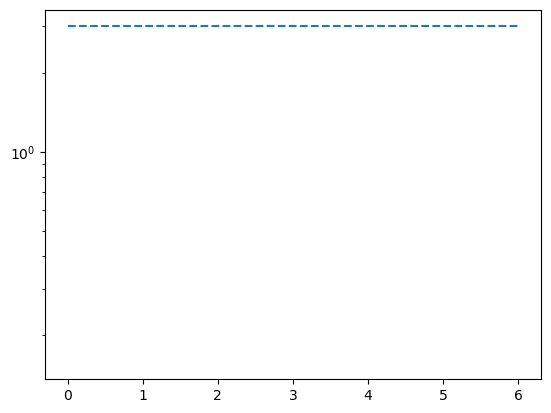

In [ ]:
Z = np.array([[1,0],[0,-1]])
X = np.array([[0,1],[1,0]])
H = H_ising_gen(L=4, op_l=Z, op_t=X, J=-1, h_l=0, h_t=0)
e,v = np.linalg.eig(H)
print(e[0], e[0]**2+1-2*e[0])
plt.plot(np.abs(energies))
plt.hlines(y=np.abs(e[0]), xmin=0, xmax=6, linestyle='--')
plt.semilogy()

In [ ]:
np.abs((energies[-1] - e[0])/energies[-1])

In [ ]:
errors

[-3.000064060873929,
 -3.000064070440773,
 -3.0000640642770655,
 -3.0000640703491634,
 -3.000064057409283]

In [18]:
spin = MPS(L=4, d=2, model="Ising", chi=4, J=1, h=0, eps=0)
spin._random_state(seed=3, chi=4)
spin.canonical_form()
energies = spin.sweeping(trunc=False)
print(energies)

Sweep n: 0


Optimal Schmidt values achieved, breaking the DMRG optimization algorithm

Sweep n: 1

[-1.5329019075206443, -2.9999999999999982, -3.0000000000000036, -3.0000000000000004, -3.000000000000002, -2.9999999999999987]


In [19]:
psi = mps_to_vector(spin.sites)

In [36]:
delta = 0.001
Z = np.array([[1,0],[0,-1]])
X = np.array([[0,1],[1,0]])
H = H_ising_gen(L=4, op_l=Z, op_t=X, J=1, h_l=0, h_t=0)
U = expm(-1j*delta*H)
for i in range(5):
    psi_new = ncon([U,psi],[[-1,1],[1]])

    eigval = ncon([psi_new.conjugate() , H , psi_new],[[1],[1,2],[2]]).real
    psi = psi_new
    print(f"energy at trotter step {i}: {eigval}")

energy at trotter step 0: -2.999999999999998
energy at trotter step 1: -2.999999999999998
energy at trotter step 2: -2.9999999999999982
energy at trotter step 3: -2.9999999999999973
energy at trotter step 4: -2.9999999999999973


In [35]:
spin.mpo_Ising_time_ev(delta=delta, h_ev=0.1, J_ev=1)
mpo = spin.w
H_mpo = mpo_to_matrix(mpo)
U_mpo = expm(-1j*delta*H_mpo)
for i in range(5):
    psi_new = ncon([U_mpo,psi],[[-1,1],[1]])

    eigval = ncon([psi_new.conjugate() , H_mpo , psi_new],[[1],[1,2],[2]]).real
    psi = psi_new
    # print(psi_new)
    print(f"energy at trotter step {i}: {eigval}")

NameError: name 'spin' is not defined

In [ ]:
print(H_mpo.real)

[[ 9.99995320e-01 -5.99999264e-07 -2.99999332e-07 -8.99998542e-08
  -2.99999332e-07 -8.99997642e-08 -8.99998542e-08 -2.41069695e-36
  -5.99999264e-07 -8.99998542e-08 -8.99997642e-08  2.41069535e-30
  -8.99998542e-08  2.41069535e-30 -2.41069695e-36  8.09998736e-15]
 [-5.99999264e-07  9.99999320e-01 -8.99998542e-08 -2.99999932e-07
  -8.99997642e-08  2.99999332e-07  2.41069695e-36 -8.99998542e-08
  -8.99998542e-08  4.29490018e-23  2.41069535e-30 -8.99999442e-08
  -2.41069535e-30 -8.99998542e-08  8.09998736e-15  2.41069695e-36]
 [-2.99999332e-07 -8.99998542e-08  9.99999320e-01 -6.04105306e-23
  -8.99998542e-08 -2.41069695e-36  2.99999932e-07 -8.99999442e-08
  -8.99997642e-08  2.41069535e-30  5.99999264e-07 -8.99998542e-08
  -2.41069695e-36  8.09998736e-15 -8.99998542e-08 -2.41069535e-30]
 [-8.99998542e-08 -2.99999932e-07 -1.13981589e-22  9.99999320e-01
   2.41069695e-36 -8.99998542e-08 -8.99999442e-08 -2.99999932e-07
   2.41069535e-30 -8.99999442e-08 -8.99998542e-08 -9.58885610e-23
   8.09

In [37]:
print(U)

[[0.9999955+0.003j 0.       +0.j    0.       +0.j    0.       +0.j
  0.       +0.j    0.       +0.j    0.       +0.j    0.       +0.j
  0.       +0.j    0.       +0.j    0.       +0.j    0.       +0.j
  0.       +0.j    0.       +0.j    0.       +0.j    0.       +0.j   ]
 [0.       +0.j    0.9999995+0.001j 0.       +0.j    0.       +0.j
  0.       +0.j    0.       +0.j    0.       +0.j    0.       +0.j
  0.       +0.j    0.       +0.j    0.       +0.j    0.       +0.j
  0.       +0.j    0.       +0.j    0.       +0.j    0.       +0.j   ]
 [0.       +0.j    0.       +0.j    0.9999995-0.001j 0.       +0.j
  0.       +0.j    0.       +0.j    0.       +0.j    0.       +0.j
  0.       +0.j    0.       +0.j    0.       +0.j    0.       +0.j
  0.       +0.j    0.       +0.j    0.       +0.j    0.       +0.j   ]
 [0.       +0.j    0.       +0.j    0.       +0.j    0.9999995+0.001j
  0.       +0.j    0.       +0.j    0.       +0.j    0.       +0.j
  0.       +0.j    0.       +0.j    0.       +0

In [2]:
def mpo_Ising_time_ev(classe, delta, h_ev, J_ev):
    """
    mpo_Ising_time_ev

    This function defines the MPO for the real time evolution of a 1D transverse field Ising model.
    We use this to perform a second order TEBD.

    delta: float - Trotter step for the time evolution
    h_ev: float - parameter of the local field for the quench
    J_ev: float - parameter of the interaction field for the quench

    """
    I = np.eye(2)
    O = np.zeros((2,2))
    X = np.array([[0,1],[1,0]])
    Z = np.array([[1,0],[0,-1]])
    w_tot = []
    w_loc = np.array(expm(-1j*h_ev*delta/2*X)) 
    w_in = np.array([[np.sqrt(np.cos(J_ev*delta))*I, -1j*np.sqrt(np.sin(J_ev*delta))*Z]])
    w_in = ncon([w_in, w_loc, w_loc],[[-1,-2,1,2],[-3,1],[2,-4]])
    w_fin = np.array([[np.sqrt(np.cos(J_ev*delta))*I, np.sqrt(np.sin(J_ev*delta))*Z]])
    # w_fin = np.swapaxes(w_fin, axis1=0,axis2=1)
    w_fin = ncon([w_fin.T, w_loc, w_loc],[[1,2,-1,-2],[-3,1],[2,-4]])
    w_tot.append(w_in)
    for _ in range(1, classe.L-1):
        w = np.array([[np.cos(J_ev*delta)*I,-1j*np.sqrt(np.cos(J_ev*delta)*np.sin(J_ev*delta))*Z],[np.sqrt(np.cos(J_ev*delta)*np.sin(J_ev*delta))*Z, -1j*np.sin(J_ev*delta)*I]])
        w = ncon([w, w_loc, w_loc],[[-1,-2,1,2],[-3,1],[2,-4]])
        w_tot.append(w)
    
    w_tot.append(w_fin)
    classe.w = w_tot
    return classe

In [3]:
classe = MPS(L=4, d=2, model="Ising", chi=4, h=0, J=1, eps=0)
mpo_Ising_time_ev(classe, delta=0.001, h_ev=0.1, J_ev=1)
mpo = classe.w
tensor_shapes(mpo)

(1, 2, 2, 2)
(2, 2, 2, 2)
(2, 2, 2, 2)
(2, 1, 2, 2)


[(1, 2, 2, 2), (2, 2, 2, 2), (2, 2, 2, 2), (2, 1, 2, 2)]

In [4]:
U_mpo = mpo_to_matrix(mpo)
U_mpo = truncation(array=U_mpo, threshold=1e-15)
U_new_mpo = csr_matrix(U_mpo)

In [5]:
delta = 0.001
Z = np.array([[1,0],[0,-1]])
X = np.array([[0,1],[1,0]])
H = H_ising_gen(L=4, op_l=Z, op_t=X, J=1, h_l=0, h_t=0.1)
U = expm(-1j*delta*H)
U_new = truncation(array=U, threshold=1e-15)
U_new=csr_matrix(U_new)

In [6]:
print(U_new)

  (0, 0)	(0.9999954800034219+0.002999995460002063j)
  (0, 1)	(-1.999998313333851e-07+9.999978166676941e-05j)
  (0, 2)	(-9.999991566669256e-08+9.999988166671875e-05j)
  (0, 3)	(-9.999988200003838e-09-1.3333325893335078e-11j)
  (0, 4)	(-9.999991566669256e-08+9.999988166671876e-05j)
  (0, 5)	(-9.999991533335934e-09+8.077935669463161e-28j)
  (0, 6)	(-9.999994866668028e-09-3.333330960000576e-12j)
  (0, 8)	(-1.9999983133338506e-07+9.999978166676941e-05j)
  (0, 9)	(-9.99999153333593e-09-9.999994933334496e-12j)
  (0, 10)	(-9.999991533335934e-09-1.7433675301366213e-27j)
  (0, 12)	(-9.999988200003841e-09-1.3333325893335081e-11j)
  (1, 0)	(-1.9999983133338503e-07+9.999978166676941e-05j)
  (1, 1)	(0.9999994800000551+0.0009999998200000129j)
  (1, 2)	(-9.999994866668028e-09-6.6666639733339206e-12j)
  (1, 3)	(-9.99999823333344e-08+9.99999483333382e-05j)
  (1, 4)	(-9.99999153333593e-09-1.84774326134297e-27j)
  (1, 5)	(9.99999156666925e-08+9.999988166671873e-05j)
  (1, 7)	(-9.999994866667585e-09-3.3333

In [7]:
print(U_new_mpo)

  (0, 0)	(0.9999954800034256-0.002999995470002071j)
  (0, 1)	(-1.9999976533343662e-07-9.999974833350739e-05j)
  (0, 2)	(-9.999978266676898e-08-9.99997483335074e-05j)
  (0, 3)	(-9.999984866675622e-09+9.999988300005125e-12j)
  (0, 4)	(-9.9999782666769e-08-9.99997483335074e-05j)
  (0, 5)	(-9.99997486668399e-09+6.696369420886477e-28j)
  (0, 6)	(-9.999984866675623e-09-9.999994966667772e-18j)
  (0, 8)	(-1.999997653334366e-07-9.999974833350739e-05j)
  (0, 9)	(-9.99998486667562e-09+9.999988300005124e-12j)
  (0, 10)	(-9.999974866683988e-09+6.696369420886478e-28j)
  (0, 12)	(-9.999984866675623e-09+9.999988300005127e-12j)
  (1, 0)	(-1.9999976533343662e-07-9.999974833350739e-05j)
  (1, 1)	(0.9999994800000722-0.0009999998233333437j)
  (1, 2)	(-9.999984866675622e-09+9.999988300005125e-12j)
  (1, 3)	(-9.999998266666764e-08-9.999994833333939e-05j)
  (1, 4)	(-9.99997486668399e-09-6.696369420886477e-28j)
  (1, 5)	(9.9999782666769e-08-9.99997483335074e-05j)
  (1, 7)	(-9.999984866675623e-09+9.999994966667

In [71]:
np.isclose(U_new, U_new_mpo)

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''